In [20]:
pip install kaggle


In [21]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [22]:
!kaggle competitions download -c shl-intern-hiring-assessment

In [24]:
!unzip shl-intern-hiring-assessment.zip -d shl_data


Archive:  shl-intern-hiring-assessment.zip
  inflating: shl_data/Dataset/audios/test/audio_1001.wav  
  inflating: shl_data/Dataset/audios/test/audio_1006.wav  
  inflating: shl_data/Dataset/audios/test/audio_1011.wav  
  inflating: shl_data/Dataset/audios/test/audio_1025.wav  
  inflating: shl_data/Dataset/audios/test/audio_1028.wav  
  inflating: shl_data/Dataset/audios/test/audio_1039.wav  
  inflating: shl_data/Dataset/audios/test/audio_1041.wav  
  inflating: shl_data/Dataset/audios/test/audio_1046.wav  
  inflating: shl_data/Dataset/audios/test/audio_1055.wav  
  inflating: shl_data/Dataset/audios/test/audio_1059.wav  
  inflating: shl_data/Dataset/audios/test/audio_1069.wav  
  inflating: shl_data/Dataset/audios/test/audio_1079.wav  
  inflating: shl_data/Dataset/audios/test/audio_108.wav  
  inflating: shl_data/Dataset/audios/test/audio_1088.wav  
  inflating: shl_data/Dataset/audios/test/audio_1090.wav  
  inflating: shl_data/Dataset/audios/test/audio_1092.wav  
  inflating: s

In [25]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [27]:
train_df = pd.read_csv('/content/shl_data/Dataset/test.csv')
test_df = pd.read_csv('/content/shl_data/Dataset/test.csv')

train_df.head(), test_df.head()


(         filename
 0   audio_804.wav
 1  audio_1028.wav
 2   audio_865.wav
 3   audio_774.wav
 4  audio_1138.wav,
          filename
 0   audio_804.wav
 1  audio_1028.wav
 2   audio_865.wav
 3   audio_774.wav
 4  audio_1138.wav)

In [29]:
missing_files = []
for filename in train_df['filename']:
    audio_path = os.path.join('shl_data/Dataset/audios/train', filename)
    if not os.path.exists(audio_path):
        missing_files.append(filename)
if missing_files:
    print(f"Missing files: {missing_files}")
else:
    print("All files are present.")


Missing files: ['audio_804.wav', 'audio_1028.wav', 'audio_865.wav', 'audio_774.wav', 'audio_1138.wav', 'audio_278.wav', 'audio_1212.wav', 'audio_178.wav', 'audio_542.wav', 'audio_248.wav', 'audio_872.wav', 'audio_954.wav', 'audio_853.wav', 'audio_171.wav', 'audio_922.wav', 'audio_915.wav', 'audio_1220.wav', 'audio_1225.wav', 'audio_903.wav', 'audio_748.wav', 'audio_284.wav', 'audio_200.wav', 'audio_1255.wav', 'audio_1246.wav', 'audio_1102.wav', 'audio_1300.wav', 'audio_80.wav', 'audio_1041.wav', 'audio_256.wav', 'audio_328.wav', 'audio_301.wav', 'audio_938.wav', 'audio_1055.wav', 'audio_664.wav', 'audio_89.wav', 'audio_407.wav', 'audio_1025.wav', 'audio_72.wav', 'audio_1316.wav', 'audio_661.wav', 'audio_822.wav', 'audio_956.wav', 'audio_1329.wav', 'audio_1218.wav', 'audio_1286.wav', 'audio_1166.wav', 'audio_1231.wav', 'audio_501.wav', 'audio_188.wav', 'audio_746.wav', 'audio_218.wav', 'audio_168.wav', 'audio_689.wav', 'audio_234.wav', 'audio_670.wav', 'audio_241.wav', 'audio_1226.wav',

In [30]:
import os
available_files = set(os.listdir('shl_data/Dataset/audios/train'))
train_df = train_df[train_df['filename'].isin(available_files)]

print(f"Remaining samples in train.csv: {len(train_df)}")


Remaining samples in train.csv: 0


In [31]:
print(train_df.head())

print(train_df.columns)


Empty DataFrame
Columns: [filename]
Index: []
Index(['filename'], dtype='object')


In [68]:
def extract_mfcc(audio_path, n_mfcc=13, sr=16000):
    y, sr = librosa.load(audio_path, sr=sr, duration=60.0)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)


train_features = []
for filename in train_df['filename']:
    audio_path = os.path.join('shl_data/Dataset/audios/train', filename)
    mfcc = extract_mfcc(audio_path, n_mfcc=13)
    train_features.append(mfcc)

test_features = []
for filename in test_df['filename']:
    audio_path = os.path.join('shl_data/Dataset/audios/test', filename)
    mfcc = extract_mfcc(audio_path, n_mfcc=13)
    test_features.append(mfcc)

X_train = np.array(train_features)
X_test = np.array(test_features)


In [33]:
print([repr(col) for col in train_df.columns])


["'filename'"]


In [34]:
train_df = pd.read_csv('/content/shl_data/Dataset/train.csv')

print(train_df.head())
print(train_df.columns)


         filename  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0
Index(['filename', 'label'], dtype='object')


In [35]:
train_df.columns = train_df.columns.str.strip()

print(train_df.columns)


Index(['filename', 'label'], dtype='object')


In [61]:
y_train = train_df['label'].values


In [69]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [71]:
import librosa
import numpy as np

def extract_mfcc_features(audio_path, n_mfcc=13, sr=16000):
    y, sr = librosa.load(audio_path, sr=sr, duration=60.0)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    combined = np.vstack([mfcc, delta, delta2])
    feature_vector = np.mean(combined, axis=1)
    return feature_vector


In [73]:
"""train_features = []
for filename in train_df['filename']:
    audio_path = os.path.join('shl_data/Dataset/audios/train', filename)
    train_features.append(extract_mfcc_features(audio_path))

test_features = []
for filename in test_df['filename']:
    audio_path = os.path.join('shl_data/Dataset/audios/test', filename)
    test_features.append(extract_mfcc_features(audio_path))

X_train = np.array(train_features)
X_test = np.array(test_features)
"""

train_features = []
for filename in train_df['filename']:
    audio_path = os.path.join('shl_data/Dataset/audios/train', filename)
    mfcc = extract_mfcc(audio_path)
    train_features.append(mfcc)

test_features = []
for filename in test_df['filename']:
    audio_path = os.path.join('shl_data/Dataset/audios/test', filename)
    mfcc = extract_mfcc(audio_path)
    test_features.append(mfcc)

X_train = np.array(train_features)
X_test = np.array(test_features)
y_train = train_df['label'].values


In [74]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [75]:
from sklearn.metrics import mean_squared_error
import numpy as np

train_preds = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, train_preds))
print("Final RMSE on Training Data:", rmse)


Final RMSE on Training Data: 0.3479579262906199


In [77]:
test_predictions = model.predict(X_test)
submission = pd.read_csv('/content/shl_data/Dataset/sample_submission.csv')
submission['label'] = test_predictions
submission.to_csv('submission.csv', index=False)


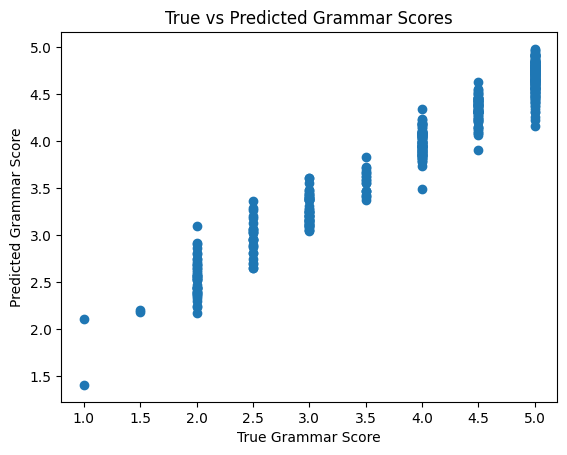

In [78]:
plt.scatter(y_train, y_train_pred)
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("True vs Predicted Grammar Scores")
plt.show()


In [82]:
import pandas as pd
submission = pd.read_csv("/content/shl_data/Dataset/sample_submission.csv")
y_pred = model.predict(X_test)

submission['label'] = y_pred

submission.to_csv("submission.csv", index=False)

print("Submission file saved as 'submission.csv'")


Submission file saved as 'submission.csv'
